In [ ]:
!pip install git+https://github.com/huggingface/transformers accelerate
!pip install transformers==4.57.0
# It's highly recommanded to use `[decord]` feature for faster video loading.
# !pip install qwen-vl-utils[decord]==0.0.8
# !pip install torchvision>=0.19.0

In [1]:
# !pip uninstall -y flash-attn torch torchvision torchaudio
# !pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip uninstall flash-attn -y
# !pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.5.8/flash_attn-2.5.8+cu122torch2.3cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

In [1]:
import os
import re
import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ===================================================================
# 헬퍼 함수 및 데이터셋 클래스 정의 (제공해주신 코드)
# ===================================================================

def infer_lang_from_path(traj_path):
    match = re.search(r"datacol2_([^/]+)/([^/]+)/", traj_path)
    if match:
        env = match.group(1).replace("_", " ")
        task = match.group(2).replace("_", " ")
        return f"{task} task in the {env}"
    else:
        return "<no_lang>"

class BridgeRawSequenceDataset(Dataset):
    def __init__(self, root, horizon=8, max_traj=None):
        self.root = root
        self.horizon = horizon

        policy_files = glob.glob(
            os.path.join(
                root, "datacol2_*", "*", "*", "*", "raw", "traj_group*", "traj*", "policy_out.pkl"
            ),
            recursive=False
        )
        self.traj_paths = [os.path.dirname(p) for p in policy_files]
        print(f"✅ Found {len(self.traj_paths)} trajectories across all tasks")

        if max_traj:
            self.traj_paths = self.traj_paths[:max_traj]

        print("Scanning max views across all trajectories...")
        self.max_views = 0
        for traj_path in tqdm(self.traj_paths):
            view_dirs = [d for d in os.listdir(traj_path) if d.startswith("images")]
            self.max_views = max(self.max_views, len(view_dirs))
        print(f"✅ Max number of views across dataset: {self.max_views}")

        self.samples = self._index_chunks()

    def _index_chunks(self):
        samples = []
        print("Indexing chunks from trajectories...")
        for traj_path in tqdm(self.traj_paths):
            img_dir = os.path.join(traj_path, "images0")
            imgs = sorted(glob.glob(os.path.join(img_dir, "im_*.jpg")))
            if not imgs:
                continue
            T = len(imgs)
            chunk_count = max(T - self.horizon, 0) # horizon+1 이 아닌 horizon으로 수정
            for i in range(chunk_count):
                samples.append((traj_path, i))
        print(f"✅ Indexed {len(samples)} chunks from {len(self.traj_paths)} trajectories")
        return samples
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        traj_path, start_idx = self.samples[idx]

        view_dirs = sorted([d for d in os.listdir(traj_path) if d.startswith("images")])
        num_views = len(view_dirs)

        t = start_idx
        views = []
        for v in range(num_views):
            img_path = os.path.join(traj_path, f"images{v}", f"im_{t}.jpg")
            if os.path.exists(img_path):
                views.append(f"file://{os.path.abspath(img_path)}")

        if len(views) < self.max_views:
            views += [None] * (self.max_views - len(views))
        views = views[:self.max_views]

        with open(os.path.join(traj_path, "policy_out.pkl"), "rb") as f:
            actions = pickle.load(f)
            if isinstance(actions[0], dict):
                actions = [a.get("actions") for a in actions if "actions" in a]
        actions = np.array(actions, dtype=np.float32)

        start = start_idx
        end = start_idx + self.horizon
        if end > len(actions):
            act_seq = actions[start:len(actions)]
            last_action = act_seq[-1] if len(act_seq) > 0 else np.zeros(actions.shape[1], dtype=np.float32)
            repeat_len = end - len(actions)
            pad = np.tile(last_action, (repeat_len, 1))
            act_seq = np.concatenate([act_seq, pad], axis=0)
        else:
            act_seq = actions[start:end]

        act_seq = torch.tensor(act_seq, dtype=torch.float32)

        lang_path = os.path.join(traj_path, "lang.txt")
        lang = ""
        confidence = 0.5
        if os.path.exists(lang_path):
            with open(lang_path, "r") as f:
                lines = [l.strip() for l in f.readlines() if l.strip()]
            if len(lines) == 1:
                lang = lines[0]
            elif len(lines) >= 2:
                lang = lines[0]
                for line in lines[1:]:
                    if "confidence" in line.lower():
                        try:
                            confidence = float(line.split(":")[-1].strip())
                        except:
                            confidence = 0.5
        else:
            lang = infer_lang_from_path(traj_path)
        
        cache_key = f"{traj_path}::t={t}"

        return {"images": views, "actions": act_seq, "instruction": lang, "confidence": confidence, "cache_key": cache_key}

def collate_fn(batch):
    # images 리스트는 패딩 때문에 None을 포함할 수 있습니다.
    # 모델에 따라 None을 처리하는 방식이 필요할 수 있습니다.
    images = [b["images"] for b in batch]
    instructions = [b["instruction"] for b in batch]
    confidences = [b["confidence"] for b in batch]
    cache_keys = [b["cache_key"] for b in batch]
    actions = torch.stack([b["actions"] for b in batch], dim=0)
    return {
        "images": images,
        "instruction": instructions,
        "actions": actions,
        "confidence": confidences,
        "cache_keys": cache_keys,
    }

# ===================================================================
# 테스트 실행 스크립트
# ===================================================================
if __name__ == "__main__":
    # ❗❗❗ [중요] 이 경로를 실제 Bridge 데이터셋 루트 경로로 변경하세요! ❗❗❗
    DATASET_ROOT_PATH = "/home/najo/NAS/VLA/dataset/raw/bridge_data_v2" # 예시 경로

    print(f"Attempting to load dataset from: {DATASET_ROOT_PATH}")

    # 1. 데이터셋 인스턴스 생성
    # max_traj=10 으로 설정하면 10개의 trajectory만 로드하여 빠르게 테스트할 수 있습니다.
    dataset = BridgeRawSequenceDataset(root=DATASET_ROOT_PATH, horizon=8, max_traj=10)

    # 2. 데이터로더 생성
    if len(dataset) > 0:
        dataloader = DataLoader(
            dataset,
            batch_size=4,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0  # 디버깅 시에는 0으로 설정하는 것이 좋습니다.
        )

        # 3. 첫 번째 배치 데이터 확인
        print("\nFetching the first batch...")
        first_batch = next(iter(dataloader))
        print("✅ Successfully fetched a batch!")

        # 4. 결과 출력
        print("\n--- Batch Data Structure Check ---")
        print("Action shape:", first_batch['actions'].shape)

        images_per_sample = list(zip(*first_batch['images']))
        print(f"\nNumber of views per sample: {len(images_per_sample[0])}")
        print("Image paths for first sample in batch:", images_per_sample[0])
        print("Instruction for first sample in batch:", first_batch['instruction'][0])
        print("Cache keys for first sample in batch:", first_batch['cache_keys'][0])
    else:
        print("\n❌ No samples were indexed. Please check the DATASET_ROOT_PATH and the directory structure.")

Attempting to load dataset from: /home/najo/NAS/VLA/dataset/raw/bridge_data_v2
✅ Found 18840 trajectories across all tasks
Scanning max views across all trajectories...


100%|██████████| 10/10 [00:00<00:00, 14583.81it/s]


✅ Max number of views across dataset: 3
Indexing chunks from trajectories...


100%|██████████| 10/10 [00:00<00:00, 4667.08it/s]

✅ Indexed 279 chunks from 10 trajectories

Fetching the first batch...
✅ Successfully fetched a batch!

--- Batch Data Structure Check ---
Action shape: torch.Size([4, 8, 7])

Number of views per sample: 4
Image paths for first sample in batch: ('file:///home/najo/NAS/VLA/dataset/raw/bridge_data_v2/datacol2_toykitchen5/pnp_push_sweep/11/2023-07-31_17-14-24/raw/traj_group0/traj28/images0/im_20.jpg', 'file:///home/najo/NAS/VLA/dataset/raw/bridge_data_v2/datacol2_toykitchen5/pnp_push_sweep/11/2023-07-31_17-14-24/raw/traj_group0/traj40/images0/im_27.jpg', 'file:///home/najo/NAS/VLA/dataset/raw/bridge_data_v2/datacol2_toykitchen5/pnp_push_sweep/11/2023-07-31_17-14-24/raw/traj_group0/traj38/images0/im_21.jpg', 'file:///home/najo/NAS/VLA/dataset/raw/bridge_data_v2/datacol2_toykitchen5/pnp_push_sweep/11/2023-07-31_17-14-24/raw/traj_group0/traj40/images0/im_2.jpg')
Instruction for first sample in batch: pnp push sweep task in the toykitchen5
Cache keys for first sample in batch: /home/najo/NAS/

In [17]:
import json
import os
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from tqdm import tqdm

class insertionMeca500Dataset(Dataset):
    """
    Meca500 로봇의 멀티뷰 이미지와 로봇 상태를 JSON 파일로부터 로드합니다.
    - Action: 연속된 ee_pose 간의 차이(delta)를 사용합니다.
    - Observation: Left 카메라와 OAK 카메라 이미지만 사용합니다.
    """
    def __init__(self, json_path, horizon=8, instruction="Approach the white square silicone and insert the needle."):
        self.json_path = json_path
        self.horizon = horizon
        self.instruction = instruction
        
        # ### 디버깅 강화 ### 어떤 파일이 로드되는지 명확히 표시
        print(f"\n--- Loading trajectory from: {os.path.basename(json_path)} ---")
        with open(self.json_path, 'r') as f:
            self.trajectory_data = json.load(f)

        if len(self.trajectory_data) < 2:
            raise ValueError(f"Dataset {json_path} must have at least 2 timesteps to calculate delta actions.")

        absolute_poses = np.array([
            item['robot_state']['ee_pose'] for item in self.trajectory_data
        ], dtype=np.float32)
        
        self.actions = absolute_poses[1:] - absolute_poses[:-1]
        
        first_img_keys = sorted(self.trajectory_data[0]['images'].keys())
        # 이 라인에서 '_left'와 '_oak'를 모두 포함시킵니다.
        self.view_keys = [k for k in first_img_keys if k.endswith('_left') or k.endswith('_oak')]
        self.num_views = len(self.view_keys)
        
        # ### 디버깅 강화 ### 어떤 뷰가 최종 선택되었는지 출력
        print(f"Selected Views ({self.num_views} total): {self.view_keys}")

        self.samples = self._index_chunks()
        print(f"Indexed {len(self.samples)} samples from this trajectory.")

    def _index_chunks(self):
        num_actions = len(self.actions)
        chunk_count = max(num_actions - self.horizon + 1, 0)
        return list(range(chunk_count))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start_idx = self.samples[idx]
        t = start_idx

        current_data_point = self.trajectory_data[t]
        image_paths_dict = current_data_point['images']
        views = [f"file://{image_paths_dict[key]}" for key in self.view_keys]

        start = start_idx
        end = start_idx + self.horizon
        
        if end > len(self.actions):
            act_seq = self.actions[start:len(self.actions)]
            last_action = act_seq[-1] if len(act_seq) > 0 else np.zeros(self.actions.shape[1], dtype=np.float32)
            repeat_len = end - len(self.actions)
            pad = np.tile(last_action, (repeat_len, 1))
            act_seq = np.concatenate([act_seq, pad], axis=0)
        else:
            act_seq = self.actions[start:end]
            
        act_seq = torch.tensor(act_seq, dtype=torch.float32)

        lang = self.instruction
        confidence = 1.0
        cache_key = f"{os.path.basename(self.json_path)}::t={t}"

        return {
            "images": views, 
            "actions": act_seq, 
            "instruction": lang, 
            "confidence": confidence, 
            "cache_key": cache_key
        }
        
def collate_fn(batch):
    images = [b["images"] for b in batch]
    instructions = [b["instruction"] for b in batch]
    confidences = [b["confidence"] for b in batch]
    cache_keys = [b["cache_key"] for b in batch]
    actions = torch.stack([b["actions"] for b in batch], dim=0)
    return {
        "images": images,
        "instruction": instructions,
        "actions": actions,
        "confidence": confidences,
        "cache_keys": cache_keys,
    }

# --- 데이터 로딩 스크립트 ---

json_file_path_list = []
for i in range(1, 8):
    path = f'/home/najo/NAS/VLA/dataset/OCT_insertion/Captures{i}/Captures{i}_precise_9views.json'
    if os.path.exists(path):
        json_file_path_list.append(path)
    else:
        print(f"⚠️ Warning: File not found and will be skipped: {path}")

print("\n✅ Loading the following JSON files:")
print("\n".join(json_file_path_list))

datasets = [insertionMeca500Dataset(json_path=p, horizon=8) for p in json_file_path_list]
combined_dataset = ConcatDataset(datasets)

print(f"\n✅ Successfully combined {len(datasets)} datasets.")
print(f"✅ Total number of samples: {len(combined_dataset)}")

if len(combined_dataset) > 0:
    dataloader = DataLoader(
        combined_dataset,
        batch_size=4,
        num_workers=8, # num_workers는 환경에 맞게 조절하세요.
        collate_fn=collate_fn,
        prefetch_factor=4,
        pin_memory=True
    )

    first_batch = next(iter(dataloader))

    print("\n--- Batch Data Structure Check ---")
    print("Action shape:", first_batch['actions'].shape) 

    images_per_sample = list(zip(*first_batch['images'])) 
    print(f"\nNumber of views per sample: {len(images_per_sample[0])}")
    print("Image paths for first sample in batch:", images_per_sample[0])
    print("Cache key for first sample in batch:", first_batch['cache_keys'][0])


✅ Loading the following JSON files:
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures2/Captures2_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures3/Captures3_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures4/Captures4_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures5/Captures5_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures6/Captures6_precise_9views.json
/home/najo/NAS/VLA/dataset/OCT_insertion/Captures7/Captures7_precise_9views.json

--- Loading trajectory from: Captures1_precise_9views.json ---
Selected Views (5 total): ['view1_left', 'view2_left', 'view3_left', 'view4_left', 'view5_oak']
Indexed 360 samples from this trajectory.

--- Loading trajectory from: Captures2_precise_9views.json ---
Selected Views (5 total): ['view1_left', 'view2_left', 'view3_left', 'view4_left', 'view5_oak']
Indexed 162 samples from this traj


--- Batch Data Structure Check ---
Action shape: torch.Size([4, 8, 6])

Number of views per sample: 4
Image paths for first sample in batch: ('file:///home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/view1/left/zed_41182735_left_1759394647.412.jpg', 'file:///home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/view1/left/zed_41182735_left_1759394647.536.jpg', 'file:///home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/view1/left/zed_41182735_left_1759394647.665.jpg', 'file:///home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/view1/left/zed_41182735_left_1759394647.835.jpg')
Cache key for first sample in batch: Captures1_precise_9views.json::t=0


In [3]:
import re
import os
import glob
import pickle
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm

def infer_lang_from_path(traj_path):
    """
    datacol2_XXX 이후 폴더명 (env, task)을 기반으로 자연어 문장을 자동 생성
    """
    # 예: /.../datacol2_toykitchen1/pnp_push_sweep/02/.../traj1
    match = re.search(r"datacol2_([^/]+)/([^/]+)/", traj_path)
    if match:
        env = match.group(1).replace("_", " ")
        task = match.group(2).replace("_", " ")
        return f"{task} task in the {env}"
    else:
        return "<no_lang>"

class BridgeRawSequenceDataset(Dataset):
    def __init__(self, root, horizon=8, max_traj=None):
        self.root = root
        self.horizon = horizon

        policy_files = glob.glob(
            os.path.join(
                root, "datacol2_*", "*", "*", "*", "raw", "traj_group*", "traj*", "policy_out.pkl"
            ),
            recursive=False
        )
        self.traj_paths = [os.path.dirname(p) for p in policy_files]
        print(f"✅ Found {len(self.traj_paths)} trajectories across all tasks")

        
        if max_traj:
            self.traj_paths = self.traj_paths[:max_traj]

        # === 전체 dataset에서 최대 view 수 계산 ===
        self.max_views = 0
        for traj_path in tqdm(self.traj_paths, desc="Scanning max views"):
            view_dirs = [d for d in os.listdir(traj_path) if d.startswith("images")]
            self.max_views = max(self.max_views, len(view_dirs))
        print(f"✅ Max number of views across dataset: {self.max_views}")

        # === chunk 단위 인덱싱 ===
        self.samples = self._index_chunks()

    def _index_chunks(self):
        samples = []
        for traj_path in tqdm(self.traj_paths, desc="Indexing Chunks"):
            img_dir = os.path.join(traj_path, "images0")
            imgs = sorted(glob.glob(os.path.join(img_dir, "im_*.jpg")))
            if not imgs:
                continue
            T = len(imgs)
            chunk_count = max(T - self.horizon + 1, 0)
            for i in range(chunk_count):
                samples.append((traj_path, i))
        print(f"✅ Indexed {len(samples)} chunks from {len(self.traj_paths)} trajectories")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        traj_path, start_idx = self.samples[idx]

        # === 현재 t 시점의 view 4장만 불러오기 ===
        view_dirs = sorted([d for d in os.listdir(traj_path) if d.startswith("images")])
        num_views = len(view_dirs)

        t = start_idx  # 현재 시점
        views = []
        for v in range(num_views):
            img_path = os.path.join(traj_path, f"images{v}", f"im_{t}.jpg")
            if os.path.exists(img_path):
                views.append(f"file://{os.path.abspath(img_path)}")

        # 패딩 (view 부족 시)
        if len(views) < self.max_views:
            views += [None] * (self.max_views - len(views))
        views = views[:self.max_views]

        # === Action sequence ===
        with open(os.path.join(traj_path, "policy_out.pkl"), "rb") as f:
            actions = pickle.load(f)
            if isinstance(actions[0], dict):
                actions = [a.get("actions") for a in actions if "actions" in a]
        actions = np.array(actions, dtype=np.float32)

        # ✅ 부족 시 horizon을 "마지막 action 반복"으로 채우기
        start = start_idx
        end = start_idx + self.horizon
        if end > len(actions):
            act_seq = actions[start:len(actions)]
            last_action = act_seq[-1] if len(act_seq) > 0 else np.zeros(actions.shape[1], dtype=np.float32)
            repeat_len = end - len(actions)
            pad = np.tile(last_action, (repeat_len, 1))
            act_seq = np.concatenate([act_seq, pad], axis=0)
        else:
            act_seq = actions[start:end]

        act_seq = torch.tensor(act_seq, dtype=torch.float32)  # shape: [horizon, 7]

        # === Language ===
        lang_path = os.path.join(traj_path, "lang.txt")
        lang = ""
        confidence = 0.5
        if os.path.exists(lang_path):
            with open(lang_path, "r") as f:
                lines = [l.strip() for l in f.readlines() if l.strip()]
            if len(lines) == 1:
                lang = lines[0]
            elif len(lines) >= 2:
                lang = lines[0]
                for line in lines[1:]:
                    if "confidence" in line.lower():
                        try:
                            confidence = float(line.split(":")[-1].strip())
                        except:
                            confidence = 0.5
        else:
            lang = infer_lang_from_path(traj_path)

        return {"images": views, "actions": act_seq, "instruction": lang, "confidence": confidence}

# dataset = BridgeRawSequenceDataset(
#     root="/home/najo/NAS/VLA/dataset/raw/bridge_data_v2",
#     horizon=8
# )
# import random
# random_indices = random.sample(range(len(dataset)), 5)
# for i in random_indices:
#     s = dataset[i]
#     print(f"{i:5d} | {s['instruction']}")
    
# for i in random.sample(range(len(dataset)), 5):
#     s = dataset[i]
#     print(s["instruction"])
#     print("confidence:", s["confidence"])

In [5]:
import torch
import torch.nn as nn
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# =====================================
# 1️⃣ Action Expert (Temporal Decoder)
# =====================================
class QwenActionExpert(nn.Module):
    def __init__(self, vl_dim=3072, action_dim=7, horizon=8,
                 hidden_dim=1024, nhead=8, num_layers=4):
        super().__init__()
        self.horizon = horizon
        self.cond_proj = nn.Linear(vl_dim, hidden_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, horizon, hidden_dim))
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim * 4,
            dropout=0.1, batch_first=True
        )
        self.temporal_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, vl_tokens: torch.Tensor, z_chunk: torch.Tensor):
        """
        vl_tokens: (B, Tv, Dv)
        z_chunk: (B, H, A)
        """
        B, H, A = z_chunk.shape
        cond = self.cond_proj(vl_tokens.mean(dim=1, keepdim=True))  # (B,1,Hd)
        tgt = self.pos_embed.repeat(B, 1, 1)                        # (B,H,Hd)
        decoded = self.temporal_decoder(tgt, cond)                  # (B,H,Hd)
        delta = self.output_head(decoded)                           # (B,H,A)
        pred_actions = z_chunk + delta
        return pred_actions, delta


# =====================================
# 2️⃣ Full Vision-Language-Action Model
# =====================================
class QwenVLAForAction(nn.Module):
    def __init__(self,
                 vl_model_name="Qwen/Qwen2.5-VL-3B-Instruct",
                 action_dim=7, horizon=8, hidden_dim=1024):
        super().__init__()
        print(f"🚀 Loading Qwen-VL backbone: {vl_model_name}")

        self.processor = AutoProcessor.from_pretrained(vl_model_name)
        self.vl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            vl_model_name,
            torch_dtype=torch.bfloat16,
            attn_implementation="flash_attention_2",
            device_map="cuda",
        )

        self.action_expert = QwenActionExpert(
            vl_dim=self.vl_model.config.hidden_size,
            action_dim=action_dim,
            horizon=horizon,
            hidden_dim=hidden_dim
        ).to(dtype=torch.bfloat16, device="cuda")

        # Freeze base model
        print("🧊 Freezing Qwen-VL parameters...")
        for p in self.vl_model.parameters():
            p.requires_grad = False
        print("✅ Frozen.")

    # ==========================
    # forward() for fine-tuning
    # ==========================
    def forward(self, text_inputs, image_inputs, z_chunk):
        device = next(self.parameters()).device
        pooled_vl_tokens = []  # (B, 1, D) 형태 저장

        for txt, views in zip(text_inputs, image_inputs):
            msg_content = []
            for v in views:
                if v is not None:
                    msg_content.append({"type": "image", "image": v})
            msg_content.append({"type": "text", "text": txt})
            messages = [{"role": "user", "content": msg_content}]

            text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
            vision_inputs, video_inputs = process_vision_info(messages)

            inputs = self.processor(
                text=[text],
                images=vision_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            ).to(device=device, dtype=torch.bfloat16)

            with torch.no_grad():
                outputs = self.vl_model(**inputs, output_hidden_states=True, return_dict=True)
                vl_tokens = outputs.hidden_states[-1]  # (1, T_i, D)
                pooled = vl_tokens.mean(dim=1, keepdim=True)  # (1, 1, D)
                pooled_vl_tokens.append(pooled)

        # ✅ 이제 길이 불일치 없음
        vl_tokens = torch.cat(pooled_vl_tokens, dim=0)  # (B, 1, D)

        # --- predict actions ---
        z_chunk = z_chunk.to(device=device, dtype=vl_tokens.dtype)
        pred_actions, delta = self.action_expert(vl_tokens, z_chunk)
        return pred_actions, delta
    
dataset = BridgeRawSequenceDataset(
    root="/home/najo/NAS/VLA/dataset/raw/bridge_data_v2",
    horizon=8
)

✅ Found 18840 trajectories across all tasks


Scanning max views: 100%|██████████| 18840/18840 [00:00<00:00, 93861.28it/s] 


✅ Max number of views across dataset: 4


Indexing Chunks: 100%|██████████| 18840/18840 [00:01<00:00, 10630.52it/s]

✅ Indexed 609780 chunks from 18840 trajectories


## 추론 테스트

In [1]:
# !pip install matplotlib

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from model import QwenVLAForAction
from Total_Dataset import BridgeRawSequenceDataset, collate_fn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT_PATH = "./checkpoints/qwen_vla_final_1000.pt"
VL_MODEL_NAME = "Qwen/Qwen2.5-VL-3B-Instruct"

model = QwenVLAForAction(
    vl_model_name=VL_MODEL_NAME,
    action_dim=7,
    horizon=8,
    hidden_dim=1024,
    cache_dir="./cache/qwen_vl_features"
).to(DEVICE)

model.set_cache(False)  # 캐시 기능 자체는 비활성

checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()

🚀 Loading Qwen-VL backbone: Qwen/Qwen2.5-VL-3B-Instruct


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🧊 Freezing Qwen-VL parameters...
✅ Frozen.


/tmp/ipykernel_3427036/240130138.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)


QwenVLAForAction(
  (vl_model): Qwen2_5_VLForConditionalGeneration(
    (model): Qwen2_5_VLModel(
      (visual): Qwen2_5_VisionTransformerPretrainedModel(
        (patch_embed): Qwen2_5_VisionPatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-31): 32 x Qwen2_5_VLVisionBlock(
            (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
            (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
            (attn): Qwen2_5_VLVisionAttention(
              (qkv): Linear(in_features=1280, out_features=3840, bias=True)
              (proj): Linear(in_features=1280, out_features=1280, bias=True)
            )
            (mlp): Qwen2_5_VLMLP(
              (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
              (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
              (down_proj): Linear(in_featu

In [2]:
# 2. 데이터 로드
dataset = BridgeRawSequenceDataset(
    root="/home/najo/NAS/VLA/dataset/raw",
    horizon=8
)

sample = dataset[53]  # 하나의 trajectory 선택
batch = collate_fn([sample])

# 3. 모델 추론
with torch.no_grad():
    pred_actions, _ = model(
        text_inputs=batch["instruction"],
        image_inputs=batch["images"],
        z_chunk=batch["actions"],       # optional: teacher forcing 기반
        cache_keys=batch["cache_keys"]
    )

gt = batch["actions"].to(torch.float32).cpu().numpy()
pred = pred_actions.to(torch.float32).cpu().numpy()


✅ Found 16357 trajectories across all tasks


Scanning max views: 100%|██████████| 16357/16357 [00:00<00:00, 105034.99it/s]


✅ Max number of views across dataset: 5


Indexing Chunks: 100%|██████████| 16357/16357 [00:01<00:00, 12707.70it/s]


✅ Indexed 403583 chunks from 16357 trajectories


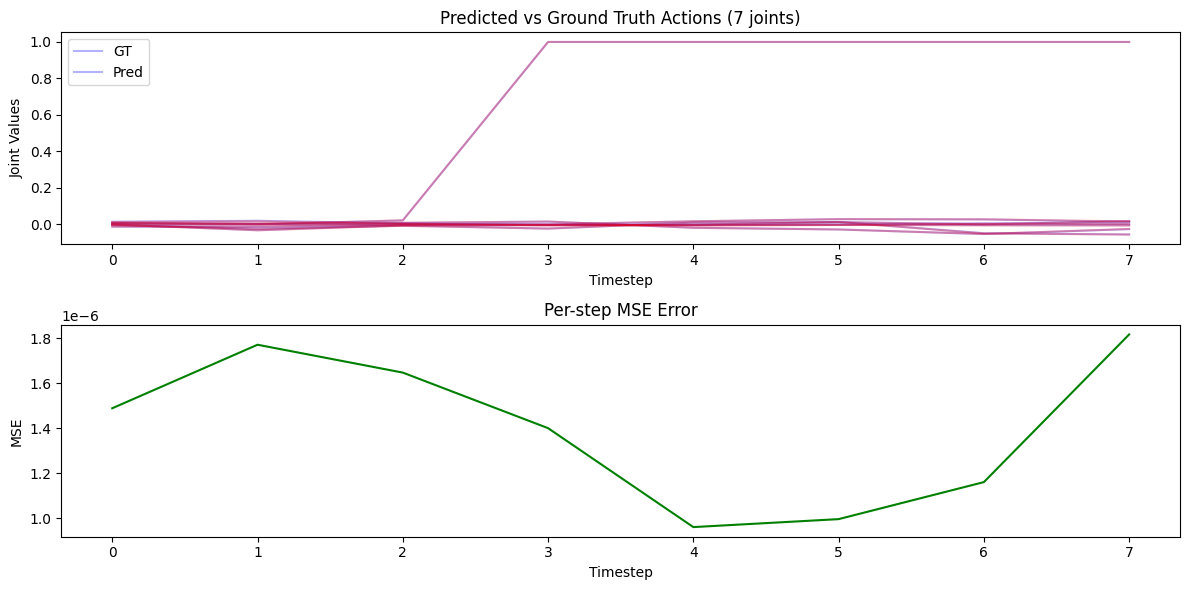

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
time = np.arange(gt.shape[1])

# 각 joint별로 평균 비교 (action_dim=7)
axes[0].plot(time, gt[0, :, :], color='blue', alpha=0.3)
axes[0].plot(time, pred[0, :, :], color='red', alpha=0.3)
axes[0].set_title("Predicted vs Ground Truth Actions (7 joints)")
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Joint Values")
axes[0].legend(["GT", "Pred"])

# 에러 곡선
mse = np.mean((gt - pred) ** 2, axis=-1)
axes[1].plot(time, mse[0], color='green')
axes[1].set_title("Per-step MSE Error")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("MSE")

plt.tight_layout()
plt.show()


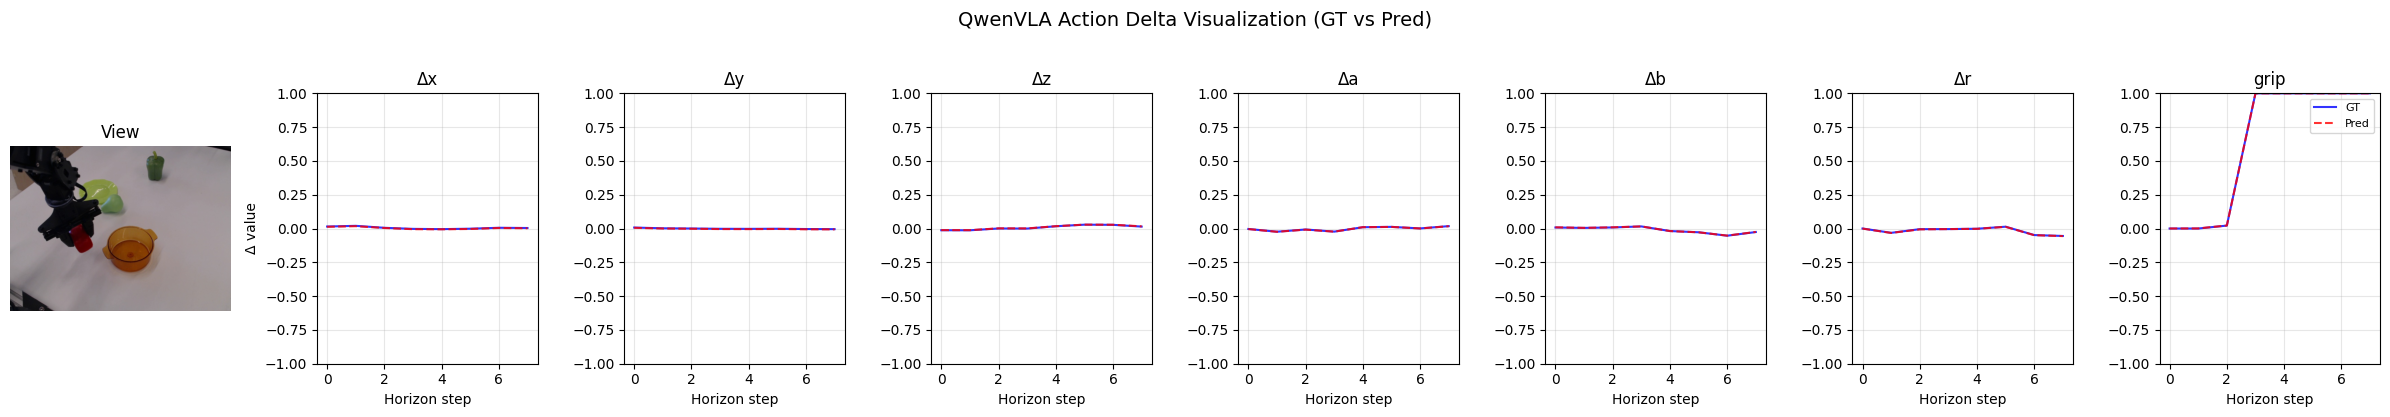

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# ---------------------------------------------------
# 1️⃣ 이미지 로드
# ---------------------------------------------------
imgs = batch["images"][0]

view_paths = []
for p in imgs:
    if isinstance(p, str) and p.startswith("file://"):
        view_paths.append(p.replace("file://", ""))
    elif isinstance(p, str):
        view_paths.append(p)
    else:
        continue

# ---------------------------------------------------
# 2️⃣ GT / Pred 액션
# ---------------------------------------------------
gt = batch["actions"].to(torch.float32).cpu().numpy()[0]     # (H, 7)
pred = pred_actions.to(torch.float32).cpu().numpy()[0]       # (H, 7)
horizon, num_joints = gt.shape

# dimension 이름
dim_labels = ["Δx", "Δy", "Δz", "Δa", "Δb", "Δr", "grip"]

# ---------------------------------------------------
# 3️⃣ Figure 구성 (왼쪽: 이미지, 오른쪽: 7개 subplot)
# ---------------------------------------------------
fig, axes = plt.subplots(1, 8, figsize=(24, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1]})
plt.subplots_adjust(wspace=0.3)

# (1) 이미지
ax_img = axes[0]
if len(view_paths) == 0:
    ax_img.text(0.5, 0.5, "🚫 No Image", ha="center", va="center", fontsize=14)
    ax_img.axis("off")
else:
    img = mpimg.imread(view_paths[0])
    ax_img.imshow(img)
    ax_img.axis("off")
    ax_img.set_title("View")

# (2) 각 dimension별 plot
for j in range(num_joints):
    ax = axes[j + 1]
    ax.plot(range(horizon), gt[:, j], 'b-', alpha=0.8, label="GT")
    ax.plot(range(horizon), pred[:, j], 'r--', alpha=0.8, label="Pred")

    ax.set_title(dim_labels[j])
    ax.set_xlabel("Horizon step")
    ax.set_ylim(-1.0, 1.0)
    if j == 0:
        ax.set_ylabel("Δ value")
    if j == num_joints - 1:
        ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("QwenVLA Action Delta Visualization (GT vs Pred)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()
